In [892]:
import pandas as pd
import numpy as np
import keras
import plotly.graph_objs as go
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas_datareader import data
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [893]:
# Define the instruments to download. We would like to see Apple, Google Amazon, Coke and Ford.
tickers = [ 'COKE']

# We would like all available data from 09/01/2019 until 09/18/2021.
start_date = '2019-09-01'
end_date =  '2021-09-18'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
# Getting just the adjusted closing prices. This will return a Pandas DataFrame
# The index in this DataFrame is the major index of the panel_data.
df = data.get_data_yahoo(tickers, start = start_date, end = end_date)

#You need to reset index using df.reset_index().
#This will make your Dates attribute/column and not an index as it is now.



In [894]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 516 entries, 2019-09-03 to 2021-09-17
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, COKE)  516 non-null    float64
 1   (Close, COKE)      516 non-null    float64
 2   (High, COKE)       516 non-null    float64
 3   (Low, COKE)        516 non-null    float64
 4   (Open, COKE)       516 non-null    float64
 5   (Volume, COKE)     516 non-null    float64
dtypes: float64(6)
memory usage: 28.2 KB
None


In [895]:
df = df.reset_index()

In [896]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   (Date, )           516 non-null    datetime64[ns]
 1   (Adj Close, COKE)  516 non-null    float64       
 2   (Close, COKE)      516 non-null    float64       
 3   (High, COKE)       516 non-null    float64       
 4   (Low, COKE)        516 non-null    float64       
 5   (Open, COKE)       516 non-null    float64       
 6   (Volume, COKE)     516 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 28.3 KB
None


In [897]:
df

Attributes,Date,Adj Close,Close,High,Low,Open,Volume
Symbols,,COKE,COKE,COKE,COKE,COKE,COKE
0,2019-09-03,331.243744,333.709991,341.209991,332.339996,335.130005,57600.0
1,2019-09-04,310.488281,312.799988,335.630005,311.440002,335.630005,104100.0
2,2019-09-05,303.569824,305.829987,316.730011,302.320007,315.000000,80400.0
3,2019-09-06,296.303894,298.510010,309.989990,295.329987,306.470001,104200.0
4,2019-09-09,290.288727,292.450012,300.489990,286.519989,300.489990,124800.0
...,...,...,...,...,...,...,...
511,2021-09-13,395.700012,395.700012,395.700012,390.399994,390.679993,14900.0
512,2021-09-14,386.029999,386.029999,394.910004,384.290009,394.910004,19000.0
513,2021-09-15,385.350006,385.350006,389.100006,383.690002,384.920013,16200.0


In [898]:
#we require only Date and Close columns, everything else can be dropped.
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [899]:
df

Attributes,Date,Close
Symbols,,COKE
0,2019-09-03,333.709991
1,2019-09-04,312.799988
2,2019-09-05,305.829987
3,2019-09-06,298.510010
4,2019-09-09,292.450012
...,...,...
511,2021-09-13,395.700012
512,2021-09-14,386.029999
513,2021-09-15,385.350006


Before we do the training and predictions, let's see how the data looks like. For all the visualizations, I’m using the Plotly python library. Why Plotly?… cause its simply the best graphing library and it can produce some good looking graphs.
With plotly, we can define a trace and the layout and it does everything else.

Data Preprocessing
For our analysis, let train the model on the first 80% of data and test it on the remaining 20%.

In [900]:
close_data = df['Close'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

412
104


Before we do the training, we need to do some major modification to our data. Remember, our data is still a sequence.. a list of numbers. The neural network is trained as a supervised model. Thus we need to convert the data from sequence to supervised data 😱.
Let me explain, training a neural network of any machine learning model requires the data to be in {<features>,<target>} format. Similarly, we need to convert the given data into this format. Here, we introduce a concept of a look back.
Look back is nothing but the number of previous days’ data to use, to predict the value for the next day. For example, let us say look back is 2; so in order to predict the stock price for tomorrow, we need the stock price of today and yesterday.
Coming back to the format, at a given day x(t), the features are the values of x(t-1), x(t-2), …., x(t-n) where n is look back.
So if our data is like this,

So if our data is like this,
[2, 3, 4, 5, 4, 6, 7, 6, 8, 9]
the required data format (n=3) would be this:
[2, 3, 4] -> [5]
[3, 4, 5] -> [4]
[4, 5, 4] -> [6]
[5, 4, 6] -> [7]
[4, 6, 7] -> [6]
[6, 7, 6] -> [8]
[7, 6, 8] -> [9]

Luckily, there is a module in Keras that does exactly this: 
TimeseriesGenerator. 

Please look up the documentation for more info.


In [901]:
look_back = 15

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

I’ve set look_back as 15, but you can play around with that value.
Neural Network
Now that our data is ready, we can move on to creating and training our network.

In [902]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 25
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/25
20/20 [==============================] - 2s 7ms/step - loss: 43472.0859
Epoch 2/25
20/20 [==============================] - 0s 7ms/step - loss: 20406.0195
Epoch 3/25
20/20 [==============================] - 0s 7ms/step - loss: 496.5875
Epoch 4/25
20/20 [==============================] - 0s 7ms/step - loss: 426.8659
Epoch 5/25
20/20 [==============================] - 0s 7ms/step - loss: 402.5451
Epoch 6/25
20/20 [==============================] - 0s 7ms/step - loss: 411.7270
Epoch 7/25
20/20 [==============================] - 0s 7ms/step - loss: 400.7021
Epoch 8/25
20/20 [==============================] - 0s 7ms/step - loss: 422.0918
Epoch 9/25
20/20 [==============================] - 0s 7ms/step - loss: 399.9176
Epoch 10/25
20/20 [==============================] - 0s 7ms/step - loss: 401.0479
Epoch 11/25
20/20 [==============================] - 0s 7ms/step - loss: 407.4051
Epoch 12/25
20/20 [==============================] - 0s 7ms/step - loss: 396.5586
Epoch 13/25
20/20 [==

A simple architecture of LSTM units trained using Adam optimizer and Mean Squared Loss function for 25 epochs. Note that instead of using model.fit(), we use model.fit_generator() because we have created a data generator.

# Prediction
Now that we have completed training, let us see if the network performed well. We can test the model on testing data and see if the prediction and the actual values overlap.


In [903]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "COKE Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close Price ($)"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()


From the graph, we can see that prediction and the actual value(ground truth) somewhat overlap. But if you zoom in, the fit is not perfect. We should expect this because it is inevitable as we are performing prediction.
Forecasting
Our testing shows the model is somewhat good. So we can move on to predicting the future or forecasting.
Foreshadowing: Since we are attempting to predict the future, there will be a great amount of uncertainty in the prediction.
Predicting the future is easy… To predict tomorrow's value, feed into the model the past n(look_back) days’ values and we get tomorrow’s value as output. To get the day after tomorrow’s value, feed-in past n-1 days’ values along with tomorrow’s value and the model output day after tomorrow’s value.
Forecasting for longer duration is not feasible. So, let’s forecast a months stock price.

In [904]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [905]:
type(forecast)

numpy.ndarray

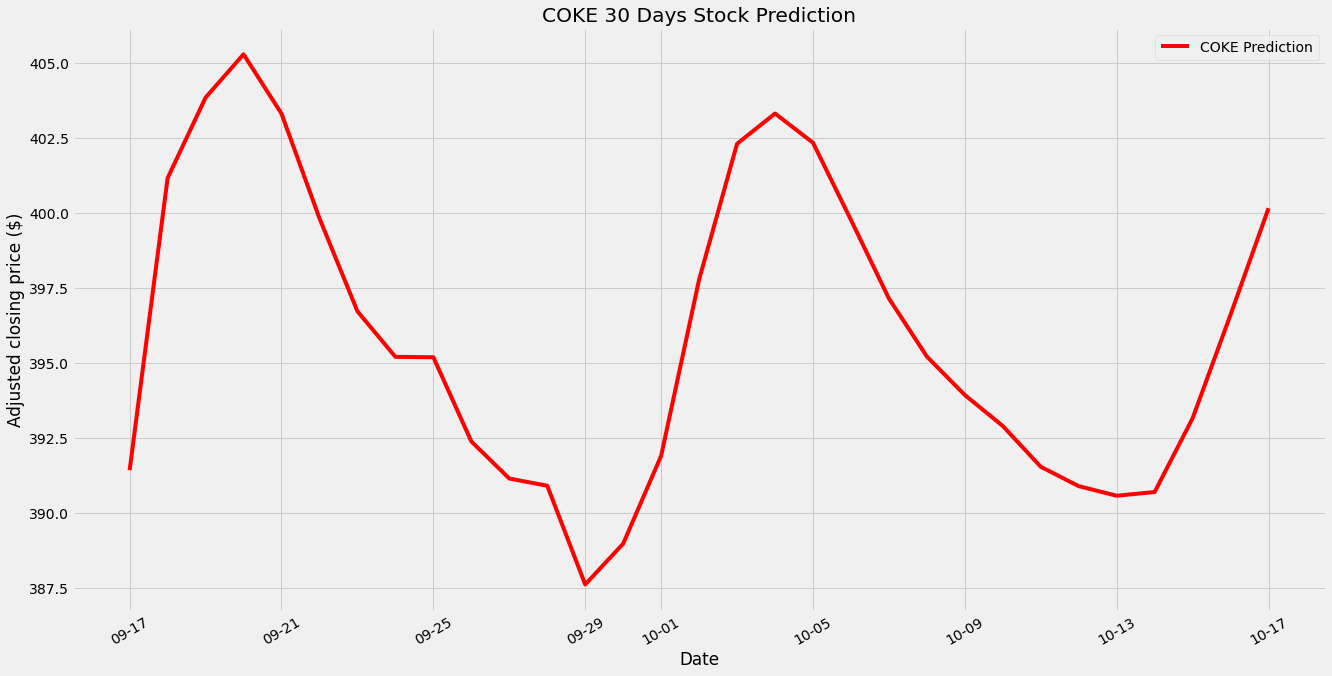

In [906]:
##plt.plot(forecast_dates, forecast, label='label here')
#plt.legend(loc='best')


# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(20,10))
plt.title('COKE 30 Days Stock Prediction')
plt.xticks(rotation = 30)
#ax.plot(df['Date'], df['Close'], label='Close Price')
ax.plot(forecast_dates, forecast, color="red", label='COKE Prediction')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted closing price ($)')
ax.legend()



In [907]:

forecast

array([391.42999268, 401.15393066, 403.83480835, 405.27655029,
       403.30026245, 399.81640625, 396.72021484, 395.20327759,
       395.19015503, 392.38690186, 391.15255737, 390.91101074,
       387.62417603, 388.98202515, 391.90737915, 397.77432251,
       402.29785156, 403.30474854, 402.33248901, 399.76141357,
       397.1463623 , 395.21252441, 393.93191528, 392.90106201,
       391.54345703, 390.89703369, 390.57897949, 390.7036438 ,
       393.15985107, 396.61032104, 400.15206909])

In [908]:
forecast_dates

[Timestamp('2021-09-17 00:00:00', freq='D'),
 Timestamp('2021-09-18 00:00:00', freq='D'),
 Timestamp('2021-09-19 00:00:00', freq='D'),
 Timestamp('2021-09-20 00:00:00', freq='D'),
 Timestamp('2021-09-21 00:00:00', freq='D'),
 Timestamp('2021-09-22 00:00:00', freq='D'),
 Timestamp('2021-09-23 00:00:00', freq='D'),
 Timestamp('2021-09-24 00:00:00', freq='D'),
 Timestamp('2021-09-25 00:00:00', freq='D'),
 Timestamp('2021-09-26 00:00:00', freq='D'),
 Timestamp('2021-09-27 00:00:00', freq='D'),
 Timestamp('2021-09-28 00:00:00', freq='D'),
 Timestamp('2021-09-29 00:00:00', freq='D'),
 Timestamp('2021-09-30 00:00:00', freq='D'),
 Timestamp('2021-10-01 00:00:00', freq='D'),
 Timestamp('2021-10-02 00:00:00', freq='D'),
 Timestamp('2021-10-03 00:00:00', freq='D'),
 Timestamp('2021-10-04 00:00:00', freq='D'),
 Timestamp('2021-10-05 00:00:00', freq='D'),
 Timestamp('2021-10-06 00:00:00', freq='D'),
 Timestamp('2021-10-07 00:00:00', freq='D'),
 Timestamp('2021-10-08 00:00:00', freq='D'),
 Timestamp

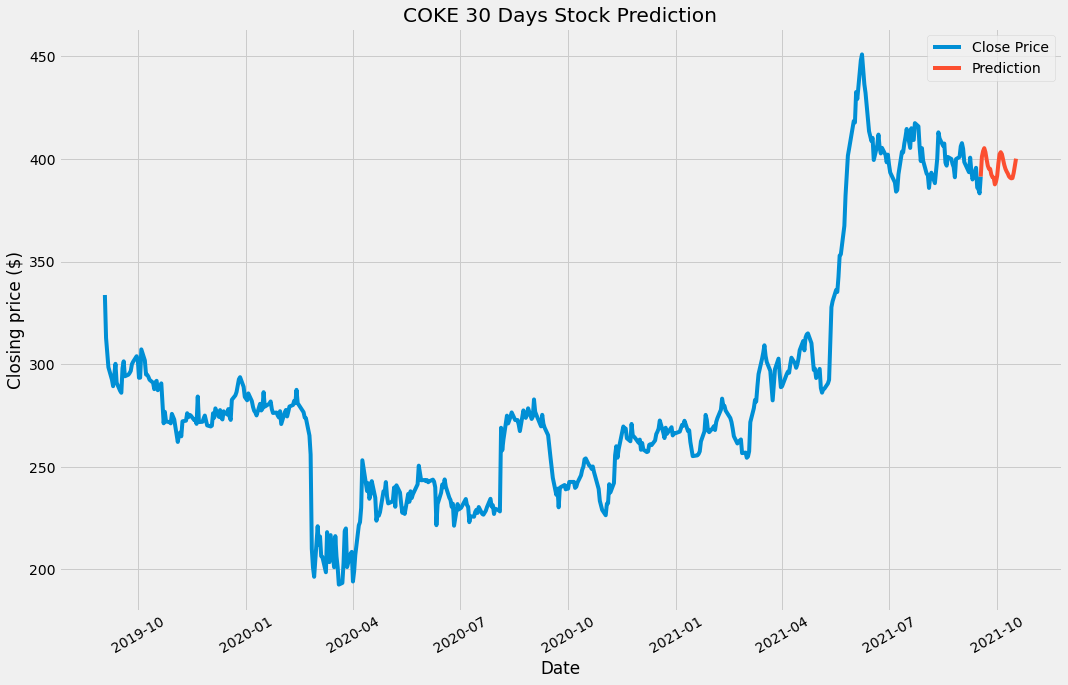

In [909]:
##plt.plot(forecast_dates, forecast, label='label here')
#plt.legend(loc='best')


# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,10))
plt.title('COKE 30 Days Stock Prediction')
plt.xticks(rotation = 30)

ax.plot(df['Date'], df['Close'], label='Close Price')
ax.plot(forecast_dates, forecast, label='Prediction')
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax.set_xlabel('Date')
ax.set_ylabel('Closing price ($)')
ax.legend()
